# Running Sirius In-Notebook

Note that this is not the preferred method of data interaction at scale, but does allow for easy access to individual pairwise charts, as well as a Plotly version of the network graph. Researchers are advised to follow the command-line data processing pipeline, and to run the Sirius application in-browser to interact with feature networks and plots.

## Import modules and libraries

In [24]:
from pathlib import Path

import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import networkx as nx

import setup
from data_processing import classify_features, load_data
from mutual_info import calc_mi
from network import output_graph_json, output_pairs_json, threshold_using_backbone_method
from visualization import draw_graph, viz, show_edge_thinning

## Select our target directory and set our parameters:
Optional: You can set up parameters from an outside file using `args = setup.arg_setup()`

In [25]:
target_dir = 'example_data' #'example_housing' #'example_groceries' #'example_icu' #'example_data'
args = {'charter': 'Plotly',
        'input_file': f'../{target_dir}/data.csv',
        'output_dir': f'../{target_dir}/output',
        'sample_n': None, #500 (recommended for example_icu)
        'output_json': True,
        'output_charts': False,
        'feature_of_interest': 'Continuous_Trinary_Normal' #'SalePrice' #'Whole Milk' #'hospital_death' #'Continuous_Trinary_Normal'
       }

## Load data

In [26]:
df = load_data(Path(args['input_file']), sample_n=args['sample_n'])

In [27]:
print(f'There are {df.shape[0]} records and {df.shape[1]} features in {args["input_file"]}')

There are 2400 records and 34 features in ../example_data/data.csv


## Classify features as discrete or continuous

In [28]:
feature_info = classify_features(df)

## Calculate mutual information for each pair of features

In [29]:
edges = calc_mi(df, feature_info).sort_values(by='v', ascending=False).reset_index(drop=True)

In [30]:
edges.head(10)

,x,y,v
0,Correlated_1,Correlated_2,6.209377
1,Quaternary_Balanced_1,Quaternary_Balanced_2,2.000000
2,Trinary_Balanced_1,Trinary_Balanced_2,1.584963
3,Continuous_Quaternary_Normal,Continuous_Quaternary_Skewed,1.400923
4,Quaternary_Balanced_2,Continuous_Quaternary_Normal,1.386920
5,Quaternary_Balanced_1,Continuous_Quaternary_Skewed,1.386920
6,Quaternary_Balanced_1,Continuous_Quaternary_Normal,1.386920
7,Quaternary_Balanced_2,Continuous_Quaternary_Skewed,1.386920
8,Quaternary_Skewed_1a,Quaternary_Skewed_1b,1.386842
9,Trinary_Balanced_2,Continuous_Trinary_Skewed,1.099029


## Dynamically threshold (sparsify) the mutual information graph (matrix) using a backbone method

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

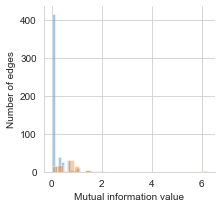

Previous edge count: 561
New edge count: 90


In [31]:
thresheld = threshold_using_backbone_method(edges)
show_edge_thinning(edges, thresheld)
print(f'Previous edge count: {edges.shape[0]}\nNew edge count: {thresheld.shape[0]}')

## View a chart and mutual information score for a selected pair of variables
Options for `charter` include `'Plotly'` or `'Seaborn'`

In [32]:
def makeviz(x,y):
    viz(x, y, df, feature_info, charter=args['charter'],display=True, resolution=100)
    print(f'Mutual information for {x} and {y}: {calc_mi(df.filter([x,y]), feature_info)["v"][0]}')

## Choose two variables to explore
### For example, we could choose two features which have a high mutual information score, chosen from our sparsified matrix:

In [52]:
choose_from_top_5 = randint(0,thresheld.shape[0])
selected1 = thresheld['x'].iloc[choose_from_top_5]
selected2 = thresheld['y'].iloc[choose_from_top_5]
print(f'Selected features {selected1} and {selected2}')

Selected features Continuous_Binary_Normal_1 and Continuous_Quaternary_Skewed


In [53]:
makeviz(selected1,selected2)

Mutual information for Continuous_Binary_Normal_1 and Continuous_Quaternary_Skewed: 11.22881869049588


### or we could choose two features at random from all possible combinations

In [54]:
random1 = edges['x'][randint(0,edges.shape[0])]
random2 = edges['x'][randint(0,edges.shape[0])]
print(f'Selected features {random1} and {random2}')

Selected features Quaternary_Extreme_1b and Quaternary_Skewed_1a


In [55]:
makeviz(random1,random2)

Mutual information for Quaternary_Extreme_1b and Quaternary_Skewed_1a: 0.4287864660940752


## Visualize the entire network graph


In [56]:
draw_graph(edges, f'Entire Edge Graph, No Thresholding: {edges.shape[0]} Connections', display=True)

## Visualize the thinned network graph

In [57]:
draw_graph(thresheld, f'Thinned Edge Graph: Reduced to {thresheld.shape[0]} Connections', display=True)

## View features related to one specific feature of interest

In [58]:
interest = args['feature_of_interest']

### What are the responses in the data for this feature?

In [59]:
df[interest].value_counts()

2.773636    1
1.062792    1
1.919029    1
1.938918    1
2.016792    1
           ..
3.116320    1
1.055358    1
2.087789    1
3.016265    1
1.843884    1
Name: Continuous_Trinary_Normal, Length: 2400, dtype: int64

### Get a list of all features directly related to this feature, with mutual information values

In [60]:
interest_edges = edges[edges['x']==interest].append(edges[edges['y']==interest]).sort_values(by='v', ascending=False)

### Visualize charts for the 5 most informative features related to this feature of interest

In [61]:
interest_edges['x'].iloc[0]

'Trinary_Balanced_2'

In [62]:
i = 0
while i < 5:
    makeviz(interest_edges['x'].iloc[i], interest_edges['y'].iloc[i])
    i+=1

Mutual information for Trinary_Balanced_2 and Continuous_Trinary_Normal: 1.5849625007211547


Mutual information for Trinary_Balanced_1 and Continuous_Trinary_Normal: 1.5849625007211547


Mutual information for Continuous_Trinary_Normal and Continuous_Trinary_Skewed: 11.22881869049588


Mutual information for Quaternary_Extreme_2 and Continuous_Trinary_Normal: 0.7416847557897402


Mutual information for Quaternary_Extreme_1b and Continuous_Trinary_Normal: 0.74168475578974


## Explore the network using a subset of second-order features related to our feature of interest

### Get a list of all related features

In [63]:
related = list(interest_edges['x'].unique())
related.append(interest)
for f in list(interest_edges['y'].unique()): related.append(f)

### Threshold again to only include these features related to our feature of interest

In [64]:
related_edges = thresheld[thresheld['x'].isin(related)].append(thresheld[thresheld['y'].isin(related)])

In [65]:
draw_graph(related_edges, f'Features of Interest Related to {interest.replace("_"," ").title()}: {related_edges.shape[0]} Connections', display=True)

### Threshold using the backbone method on the subset of connections related to the feature of interest

In [66]:
related_thresheld = threshold_using_backbone_method(related_edges)

In [71]:
draw_graph(related_thresheld, f'Features of Interest Related to {interest.replace("_"," ").title()}: {related_thresheld.shape[0]} Connections', display=True)